# Answering Questions using SQL

An SQL project using the chinook database.

![schema](chinook-schema.svg)

# Required Libraries

In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Useful sqlite functions

In [2]:
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)

In [3]:
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)

In [4]:
def show_tables():
    q = "SELECT name, type FROM sqlite_master WHERE type IN ('table', 'view');"
    return run_query(q)

In [5]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


# Top Genre's sold in the USA

This is the information I need and where to get them:
* *country* is in **customer**
* *quantity* is in **invoice line**
* *genre_id* is in **track**
* *name* is in **genre**

This is how they all link together:

**customer** *customer_id* **invoice** *invoice_id* **invoice_line** *track_id* **track** *genre_id* **genre**

In [6]:
query = '''
        WITH usa_sales AS
            (
            SELECT
                il.*
            FROM customer c
            INNER JOIN invoice i on c.customer_id=i.customer_id
            INNER JOIN invoice_line il on i.invoice_id=il.invoice_id
            WHERE c.country = "USA"
            )
            
        SELECT
            g.name genre,
            COUNT(us.quantity) tracks_sold,
            CAST(COUNT(us.quantity) AS FLOAT)/(SELECT COUNT(*) FROM usa_sales) percentage_sold
        FROM usa_sales us
        INNER JOIN track t on us.track_id=t.track_id
        INNER JOIN genre g on t.genre_id=g.genre_id
        GROUP BY genre
        ORDER BY tracks_sold DESC
        LIMIT 8
        '''
run_query(query)

,genre,tracks_sold,percentage_sold
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932


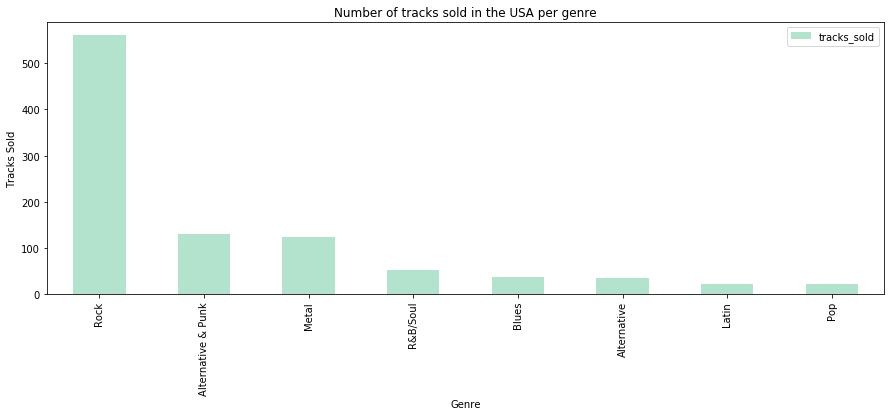

In [7]:
run_query(query).plot.bar('genre', 'tracks_sold', figsize=(15,5), colormap=plt.cm.Pastel2)
plt.title('Number of tracks sold in the USA per genre')
plt.ylabel('Tracks Sold')
plt.xlabel('Genre')
plt.show()

## Employee Performance

This is the information I need and where to get them:
* *last_name*, *first_name*, *title*, *hire_date*, *city* is in **employee**
* *total* is in **invoice**

This is how they all link together:

**employee** *employee_id*=*support_rep_id* **customer** *customer_id* **invoice**

In [8]:
query = '''
        SELECT
            e.first_name || ' ' || e.last_name employee_name,
            e.title,
            e.hire_date,
            e.city,
            SUM(i.total) sales_made
        FROM employee e
        INNER JOIN customer c on e.employee_id=c.support_rep_id
        INNER JOIN invoice i on c.customer_id=i.customer_id
        GROUP BY employee_name
        ORDER BY sales_made DESC
        '''
run_query(query)

,employee_name,title,hire_date,city,sales_made
0,Jane Peacock,Sales Support Agent,2017-04-01 00:00:00,Calgary,1731.51
1,Margaret Park,Sales Support Agent,2017-05-03 00:00:00,Calgary,1584.00
2,Steve Johnson,Sales Support Agent,2017-10-17 00:00:00,Calgary,1393.92


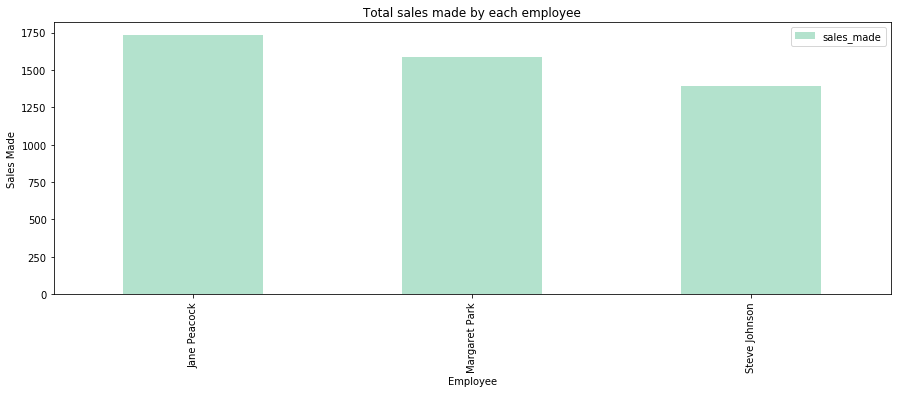

In [9]:
run_query(query).plot.bar('employee_name', 'sales_made', figsize=(15,5), colormap=plt.cm.Pastel2)
plt.title('Total sales made by each employee')
plt.ylabel('Sales Made')
plt.xlabel('Employee')
plt.show()

## Country Performance

This is the information I need and where to get them:
* *country*, *customer_id* is in **customer**
* *total*, *invoice_id* is in **invoice**

This is how they all link together:

**customer** *customer_id* **invoice**

In [10]:
query = '''
        WITH other AS
            (
            SELECT
                CASE
                    WHEN
                        (
                        SELECT
                            COUNT(*)
                            FROM customer
                            WHERE country = c.country
                        ) <= 2 
                    THEN 'Other'
                    ELSE c.country
                END AS country,
                c.customer_id
            FROM customer c
            )
        SELECT
            country,
            num_of_customers,
            total_sales,
            avg_sales_per_customer,
            avg_per_order
        FROM
            (
            SELECT
                o.country,
                COUNT(DISTINCT o.customer_id) num_of_customers,
                SUM(i.total) total_sales,
                SUM(i.total)/COUNT(DISTINCT o.customer_id) avg_sales_per_customer,
                SUM(i.total)/COUNT(DISTINCT i.invoice_id) avg_per_order,
                CASE WHEN country = "Other" THEN 1 ELSE 0 END AS sort
            FROM other o
            INNER JOIN invoice i ON o.customer_id=i.customer_id
            GROUP BY o.country
            ORDER BY sort ASC, avg_sales_per_customer DESC
            )
        '''
run_query(query)

,country,num_of_customers,total_sales,avg_sales_per_customer,avg_per_order
0,Brazil,5,427.68,85.536000,7.011148
1,Germany,4,334.62,83.655000,8.161463
2,United Kingdom,3,245.52,81.840000,8.768571
3,USA,13,1040.49,80.037692,7.942672
4,France,5,389.07,77.814000,7.781400
5,Canada,8,535.59,66.948750,7.047237
6,Other,21,1736.46,82.688571,7.649604


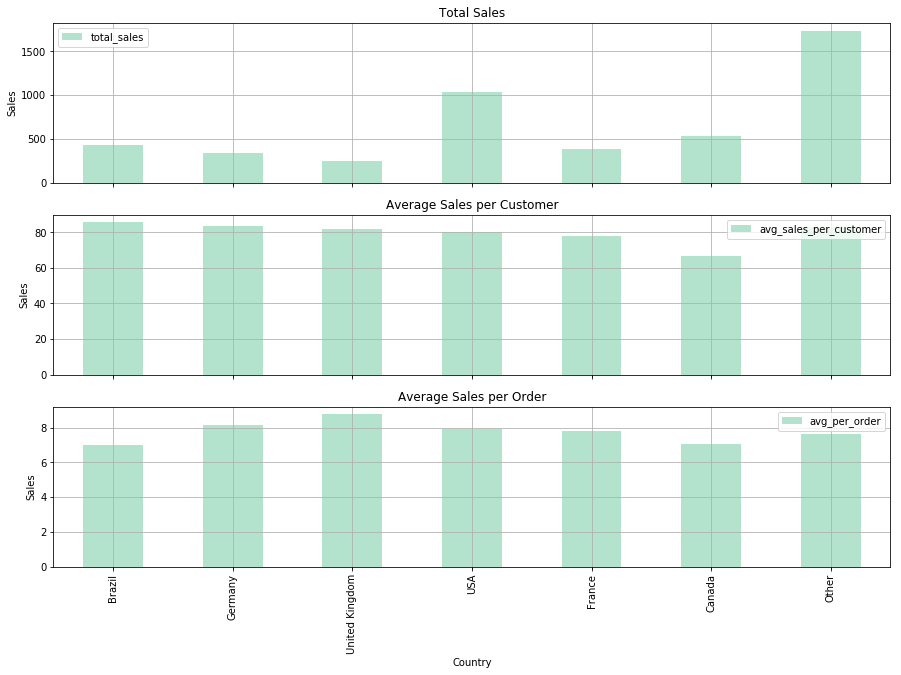

In [11]:
f, axes = plt.subplots(nrows=3, ncols=1, figsize=(15, 10), sharex=True)
ax1, ax2, ax3 = axes.flatten()

ax1 = run_query(query).plot.bar('country', 'total_sales', colormap=plt.cm.Pastel2, ax=ax1)
ax1.set_title('Total Sales')
ax1.set_ylabel('Sales')
ax1.grid()

ax2 = run_query(query).plot.bar('country', 'avg_sales_per_customer', colormap=plt.cm.Pastel2, ax=ax2)
ax2.set_title('Average Sales per Customer')
ax2.set_ylabel('Sales')
ax2.grid()

ax3 = run_query(query).plot.bar('country', 'avg_per_order', colormap=plt.cm.Pastel2, ax=ax3)
ax3.set_title('Average Sales per Order')
ax3.set_ylabel('Sales')
ax3.grid()

plt.xlabel('Country')
plt.show()

## Do people buy albums or selection of songs?

This is the information I need and where to get them:
* *track_id* is in **invoice_line**
* *invoice_id* is in **invoice**
* *album_id* is in **track**

This is how they all link together:

**invoice** *invoice_id* **invoice_line** *track_id* **track**

In [12]:
query = '''
        WITH track_from_invoice AS (
            SELECT
                il.invoice_id,
                il.track_id
            FROM invoice_line il
            GROUP BY il.invoice_id
            )
        
        SELECT
            (CAST(COUNT(tfi.invoice_id) AS FLOAT)/ (SELECT COUNT(*) FROM invoice))*100 perc_invoice,
            COUNT(tfi.invoice_id) num_invoice,
            CASE
                WHEN (
                    SELECT t.track_id FROM track t
                    WHERE t.album_id = (
                                        SELECT t2.album_id FROM track t2
                                        WHERE t2.track_id = tfi.track_id
                                        )
                    EXCEPT

                    SELECT il.track_id FROM invoice_line il
                    WHERE il.invoice_id = tfi.invoice_id
                    ) IS NULL

                AND (
                    SELECT il.track_id FROM invoice_line il
                    WHERE il.invoice_id = tfi.invoice_id

                    EXCEPT

                    SELECT t.track_id FROM track t
                    WHERE t.album_id = (
                                        SELECT t2.album_id FROM track t2
                                        WHERE t2.track_id = tfi.track_id
                                        )
                    ) IS NULL
                THEN 'YES'
                ELSE 'NO'
            END as album_purchase
        FROM track_from_invoice tfi
        GROUP BY album_purchase
        '''
run_query(query)

,perc_invoice,num_invoice,album_purchase
0,81.433225,500,NO
1,18.566775,114,YES


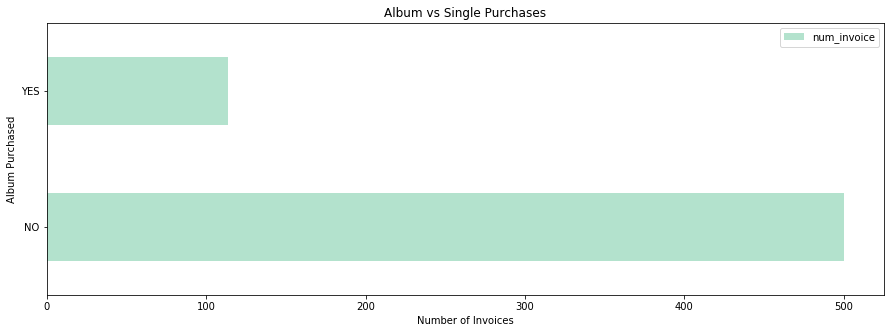

In [13]:
run_query(query).plot.barh('album_purchase', 'num_invoice', figsize=(15, 5), colormap=plt.cm.Pastel2)
plt.title('Album vs Single Purchases')
plt.ylabel('Album Purchased')
plt.xlabel('Number of Invoices')
plt.show()

## How many tracks have been purchased vs not purchased?

This is the information I need and where to get them:
* *invoice_line_id* is in **invoice_line**
* *track_id* is in **track**

This is how they all link together:

**invoice_line** *track_id* **track**

In [14]:
query = '''
        WITH
            not_purchased AS (
                SELECT
                    DISTINCT(t.track_id)
                FROM track t

                EXCEPT

                SELECT
                    DISTINCT(il.track_id)
                FROM invoice_line il
            )
        
        SELECT
            COUNT(t.track_id) num_tracks,
            CASE
                WHEN (
                    t.track_id IN (SELECT not_purchased.track_id FROM not_purchased)
                    )
                THEN 'no'
                ELSE 'yes'
            END AS purchased
        FROM track t
        GROUP BY purchased
        '''
run_query(query)

,num_tracks,purchased
0,1697,no
1,1806,yes


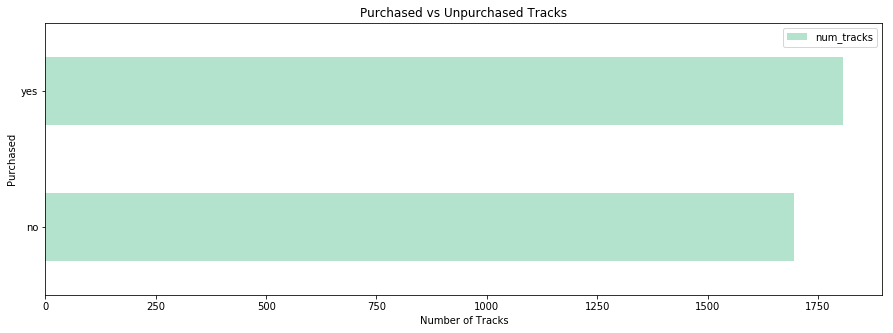

In [15]:
run_query(query).plot.barh('purchased', 'num_tracks', figsize=(15, 5), colormap=plt.cm.Pastel2)
plt.title('Purchased vs Unpurchased Tracks')
plt.ylabel('Purchased')
plt.xlabel('Number of Tracks')
plt.show()